<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W3D5_NetworkCausality/student/W3D5_Tutorial3.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D5_NetworkCausality/student/W3D5_Tutorial3.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 3: Simultaneous fitting/regression
**Week 3, Day 5: Network Causality**

**By Neuromatch Academy**

**Content creators**: Ari Benjamin, Tony Liu, Konrad Kording

**Content reviewers**: Mike X Cohen, Madineh Sarvestani, Yoni Friedman, Ella Batty, Michael Waskom

**Post-production team:** Gagana B, Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial objectives

*Estimated timing of tutorial: 20 min*

This is tutorial 3 on our day of examining causality. Below is the high level outline of what we'll cover today, with the sections we will focus on in this notebook in bold:

1. Master definitions of causality
2. Understand that estimating causality is possible
3. Learn 4 different methods and understand when they fail
    1. perturbations
    2. correlations
    3. **simultaneous fitting/regression**
    4. instrumental variables

### Notebook 3 objectives

In tutorial 2 we explored correlation as an approximation for causation and learned that correlation $\neq$ causation for larger networks. However, computing correlations is a rather simple approach, and you may be wondering: will more sophisticated techniques allow us to better estimate causality? Can't we control things? 

Here we'll use some common advanced (but controversial) methods that estimate causality from observational data. These methods rely on fitting a function to our data directly, instead of trying to use perturbations or correlations. Since we have the full closed-form equation of our system, we can try these methods and see how well they work in estimating causal connectivity when there are no perturbations. Specifically, we will:

- Learn about more advanced (but also controversial) techniques for estimating causality
    - conditional probabilities (**regression**)
- Explore limitations and failure modes
    - understand the problem of **omitted variable bias**


##  Tutorial slides


 These are the slides for the videos in all tutorials today


In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/gp4m9/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [2]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Lasso

##  Figure Settings


In [3]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Plotting Functions


In [4]:
# @title Plotting Functions

def see_neurons(A, ax, ratio_observed=1, arrows=True):
    """
    Visualizes the connectivity matrix.

    Args:
        A (np.ndarray): the connectivity matrix of shape (n_neurons, n_neurons)
        ax (plt.axis): the matplotlib axis to display on

    Returns:
        Nothing, but visualizes A.
    """
    n = len(A)

    ax.set_aspect('equal')
    thetas = np.linspace(0, np.pi * 2, n, endpoint=False)
    x, y = np.cos(thetas), np.sin(thetas),
    if arrows:
      for i in range(n):
          for j in range(n):
              if A[i, j] > 0:
                  ax.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i], color='k', head_width=.05,
                          width = A[i, j] / 25,shape='right', length_includes_head=True,
                          alpha = .2)
    if ratio_observed < 1:
      nn = int(n * ratio_observed)
      ax.scatter(x[:nn], y[:nn], c='r', s=150, label='Observed')
      ax.scatter(x[nn:], y[nn:], c='b', s=150, label='Unobserved')
      ax.legend(fontsize=15)
    else:
      ax.scatter(x, y, c='k', s=150)
    ax.axis('off')


def plot_connectivity_matrix(A, ax=None):
  """Plot the (weighted) connectivity matrix A as a heatmap

    Args:
      A (ndarray): connectivity matrix (n_neurons by n_neurons)
      ax: axis on which to display connectivity matrix
  """
  if ax is None:
    ax = plt.gca()
  lim = np.abs(A).max()
  ax.imshow(A, vmin=-lim, vmax=lim, cmap="coolwarm")

##  Helper Functions


In [5]:
# @title Helper Functions


def sigmoid(x):
    """
    Compute sigmoid nonlinearity element-wise on x.

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with sigmoid nonlinearity applied
    """
    return 1 / (1 + np.exp(-x))


def create_connectivity(n_neurons, random_state=42, p=0.9):
    """
    Generate our nxn causal connectivity matrix.

    Args:
        n_neurons (int): the number of neurons in our system.
        random_state (int): random seed for reproducibility

    Returns:
        A (np.ndarray): our 0.1 sparse connectivity matrix
    """
    np.random.seed(random_state)
    A_0 = np.random.choice([0, 1], size=(n_neurons, n_neurons), p=[p, 1 - p])

    # set the timescale of the dynamical system to about 100 steps
    _, s_vals, _ = np.linalg.svd(A_0)
    A = A_0 / (1.01 * s_vals[0])

    # _, s_val_test, _ = np.linalg.svd(A)
    # assert s_val_test[0] < 1, "largest singular value >= 1"

    return A


def simulate_neurons(A, timesteps, random_state=42):
    """
    Simulates a dynamical system for the specified number of neurons and timesteps.

    Args:
        A (np.array): the connectivity matrix
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): random seed for reproducibility

    Returns:
        - X has shape (n_neurons, timeteps).
    """
    np.random.seed(random_state)


    n_neurons = len(A)
    X = np.zeros((n_neurons, timesteps))

    for t in range(timesteps - 1):
        # solution
        epsilon = np.random.multivariate_normal(np.zeros(n_neurons), np.eye(n_neurons))
        X[:, t + 1] = sigmoid(A.dot(X[:, t]) + epsilon)

        assert epsilon.shape == (n_neurons,)
    return X


def get_sys_corr(n_neurons, timesteps, random_state=42, neuron_idx=None):
    """
    A wrapper function for our correlation calculations between A and R.

    Args:
        n_neurons (int): the number of neurons in our system.
        timesteps (int): the number of timesteps to simulate our system.
        random_state (int): seed for reproducibility
        neuron_idx (int): optionally provide a neuron idx to slice out

    Returns:
        A single float correlation value representing the similarity between A and R
    """

    A = create_connectivity(n_neurons, random_state)
    X = simulate_neurons(A, timesteps)

    R = correlation_for_all_neurons(X)

    return np.corrcoef(A.flatten(), R.flatten())[0, 1]


def correlation_for_all_neurons(X):
  """Computes the connectivity matrix for the all neurons using correlations

    Args:
        X: the matrix of activities

    Returns:
        estimated_connectivity (np.ndarray): estimated connectivity for the selected neuron, of shape (n_neurons,)
        """
  n_neurons = len(X)
  S = np.concatenate([X[:, 1:], X[:, :-1]], axis=0)
  R = np.corrcoef(S)[:n_neurons, n_neurons:]
  return R

The helper functions defined above are:
- `sigmoid`: computes sigmoid nonlinearity element-wise on input, from Tutorial 1
- `create_connectivity`: generates nxn causal connectivity matrix., from Tutorial 1
- `simulate_neurons`: simulates a dynamical system for the specified number of neurons and timesteps, from Tutorial 1
- `get_sys_corr`: a wrapper function for correlation calculations between A and R, from Tutorial 2
- `correlation_for_all_neurons`: computes the connectivity matrix for the all neurons using correlations, from Tutorial 2

---
# Section 1: Regression: recovering connectivity by model fitting

##  Video 1: Regression approach


In [6]:
# @title Video 1: Regression approach
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1m54y1q78b", width=730, height=410, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="Av4LaXZdgDo", width=730, height=410, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.titles = ['Youtube', 'Bilibili']

display(out)

You may be familiar with the idea that correlation only implies causation when there are no hidden *confounders*. This aligns with our intuition that correlation only implies causality when no alternative variables could explain away a correlation.

**A confounding example**:
Suppose you observe that people who sleep more do better in school. It's a nice correlation. But what else could explain it? Maybe people who sleep more are richer, don't work a second job, and have time to actually do homework. If you want to ask if sleep *causes* better grades, and want to answer that with correlations, you have to control for all possible confounds.

A confound is any variable that affects both the outcome and your original covariate. In our example, confounds are things that affect both sleep and grades. 

**Controlling for a confound**: 
Confonds can be controlled for by adding them as covariates in a regression. But for your coefficients to be causal effects, you need three things:
 
1. **All** confounds are included as covariates
2. Your regression assumes the same mathematical form of how covariates relate to outcomes (linear, GLM, etc.)
3. No covariates are caused *by* both the treatment (original variable) and the outcome. These are [colliders](https://en.wikipedia.org/wiki/Collider_(statistics)); we won't introduce it today (but Google it on your own time! Colliders are very counterintuitive.)

In the real world it is very hard to guarantee these conditions are met. In the brain it's even harder (as we can't measure all neurons). Luckily today we simulated the system ourselves.

##  Video 2: Fitting a GLM


In [7]:
# @title Video 2: Fitting a GLM
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV16p4y1S7yE", width=730, height=410, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="GvMj9hRv5Ak", width=730, height=410, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.titles = ['Youtube', 'Bilibili']

display(out)



Recall that in our system each neuron effects every other via:

$$
\vec{x}_{t+1} = \sigma(A\vec{x}_t + \epsilon_t), 
$$

where $\sigma$ is our sigmoid nonlinearity from before: $\sigma(x) = \frac{1}{1 + e^{-x}}$

Our system is a closed system, too, so there are no omitted variables. The regression coefficients should be the causal effect. Are they?

We will use a regression approach to estimate the causal influence of all neurons to neuron #1. Specifically, we will use linear regression to determine the $A$ in:

\begin{equation}
\sigma^{-1}(\vec{x}_{t+1}) = A\vec{x}_t + \epsilon_t ,
\end{equation}

where $\sigma^{-1}$ is the inverse sigmoid transformation, also sometimes referred to as the **logit** transformation: $\sigma^{-1}(x) = \log(\frac{x}{1-x})$.

Let $W$ be the $\vec{x}_t$ values, up to the second-to-last timestep $T-1$:

\begin{equation}
W = 
\begin{bmatrix}
\mid & \mid & ... & \mid \\ 
\vec{x}_0  & \vec{x}_1  & ... & \vec{x}_{T-1}  \\ 
\mid & \mid & ... & \mid
\end{bmatrix}_{n \times (T-1)}
\end{equation}

Let $Y$ be the $\vec{x}_{t+1}$ values for a selected neuron, indexed by $i$, starting from the second timestep up to the last timestep $T$:

\begin{equation}
Y = 
\begin{bmatrix}
x_{i,1}  & x_{i,2}  & ... & x_{i, T}  \\ 
\end{bmatrix}_{1 \times (T-1)}
\end{equation}

You will then fit the following model:

\begin{equation}
\sigma^{-1}(Y^T) = W^TV
\end{equation}

where $V$ is the $n \times 1$ coefficient matrix of this regression, which will be the estimated connectivity matrix between the selected neuron and the rest of the neurons.

**Review**: As you learned in Week 1, *lasso* a.k.a. **$L_1$ regularization** causes the coefficients to be sparse, containing mostly zeros. Think about why we want this here.

## Coding Exercise 1: Use linear regression plus lasso to estimate causal connectivities

You will now create a function to fit the above regression model and V. We will then call this function to examine how close the regression vs the correlation is to true causality.

**Code**:

You'll notice that we've transposed both $Y$ and $W$ here and in the code we've already provided below. Why is that? 

This is because the machine learning models provided in scikit-learn expect the *rows* of the input data to be the observations, while the *columns* are the variables. We have that inverted in our definitions of $Y$ and $W$, with the timesteps of our system (the observations) as the columns. So we transpose both matrices to make the matrix orientation correct for scikit-learn.


- Because of the abstraction provided by scikit-learn, fitting this regression will just be a call to initialize the `Lasso()` estimator and a call to the `fit()` function
- Use the following hyperparameters for the `Lasso` estimator:
    - `alpha = 0.01`
    - `fit_intercept = False`
- How do we obtain $V$ from the fitted model?

We will use the helper function `logit`.


 Execute this cell to enable helper function `logit`


In [8]:
# @markdown Execute this cell to enable helper function `logit`

def logit(x):
    """

    Applies the logit (inverse sigmoid) transformation

    Args:
        x (np.ndarray): the numpy data array we want to transform
    Returns
        (np.ndarray): x with logit nonlinearity applied
    """
    return np.log(x/(1-x))

In [9]:
def get_regression_estimate(X, neuron_idx):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int):  a neuron index to compute connectivity for

    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[[neuron_idx], 1:].transpose()

    # Apply inverse sigmoid transformation
    Y = logit(Y)

    ############################################################################
    ## TODO: Insert your code here to fit a regressor with Lasso. Lasso captures
    ## our assumption that most connections are precisely 0.
    ## Fill in function and remove
    raise NotImplementedError("Please complete the regression exercise")
    ############################################################################

    # Initialize regression model with no intercept and alpha=0.01
    regression = ...

    # Fit regression to the data
    regression.fit(...)

    V = regression.coef_

    return V


# Set parameters
n_neurons = 50  # the size of our system
timesteps = 10000  # the number of timesteps to take
random_state = 42
neuron_idx = 1

# Set up system and simulate
A = create_connectivity(n_neurons, random_state)
X = simulate_neurons(A, timesteps)

# Estimate causality with regression
V = get_regression_estimate(X, neuron_idx)

print("Regression: correlation of estimated connectivity with true connectivity: {:.3f}".format(np.corrcoef(A[neuron_idx, :], V)[1, 0]))

print("Lagged correlation of estimated connectivity with true connectivity: {:.3f}".format(get_sys_corr(n_neurons, timesteps, random_state, neuron_idx=neuron_idx)))

NotImplementedError: Please complete the regression exercise

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/main//tutorials/W3D5_NetworkCausality/solutions/W3D5_Tutorial3_Solution_17d9b1a7.py)



You should find that using regression, our estimated connectivity matrix has a correlation of $0.865$ with the true connectivity matrix. With correlation, our estimated connectivity matrix has a correlation of $0.703$ with the true connectivity matrix.

We can see from these numbers that multiple regression is better than simple correlation for estimating connectivity.

---
# Section 2: Partially Observed Systems

*Estimated timing to here from start of tutorial: 10 min*

If we are unable to observe the entire system, **omitted variable bias** becomes a problem. If we don't have access to all the neurons, and so therefore can't control them, can we still estimate the causal effect accurately?



##  Video 3: Omitted variable bias


In [10]:
# @title Video 3: Omitted variable bias
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1ov411i7dc", width=730, height=410, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="5CCib6CTMac", width=730, height=410, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.titles = ['Youtube', 'Bilibili']

display(out)

**Video correction**: the labels "connectivity from"/"connectivity to" are swapped in the video but fixed in the figures/demos below

We first visualize different subsets of the connectivity matrix when we observe 75% of the neurons vs 25%.

Recall the meaning of entries in our connectivity matrix: $A[i,j] = 1$ means a connectivity **from** neuron $i$ **to** neuron $j$ with strength $1$.

 Execute this cell to visualize subsets of connectivity matrix


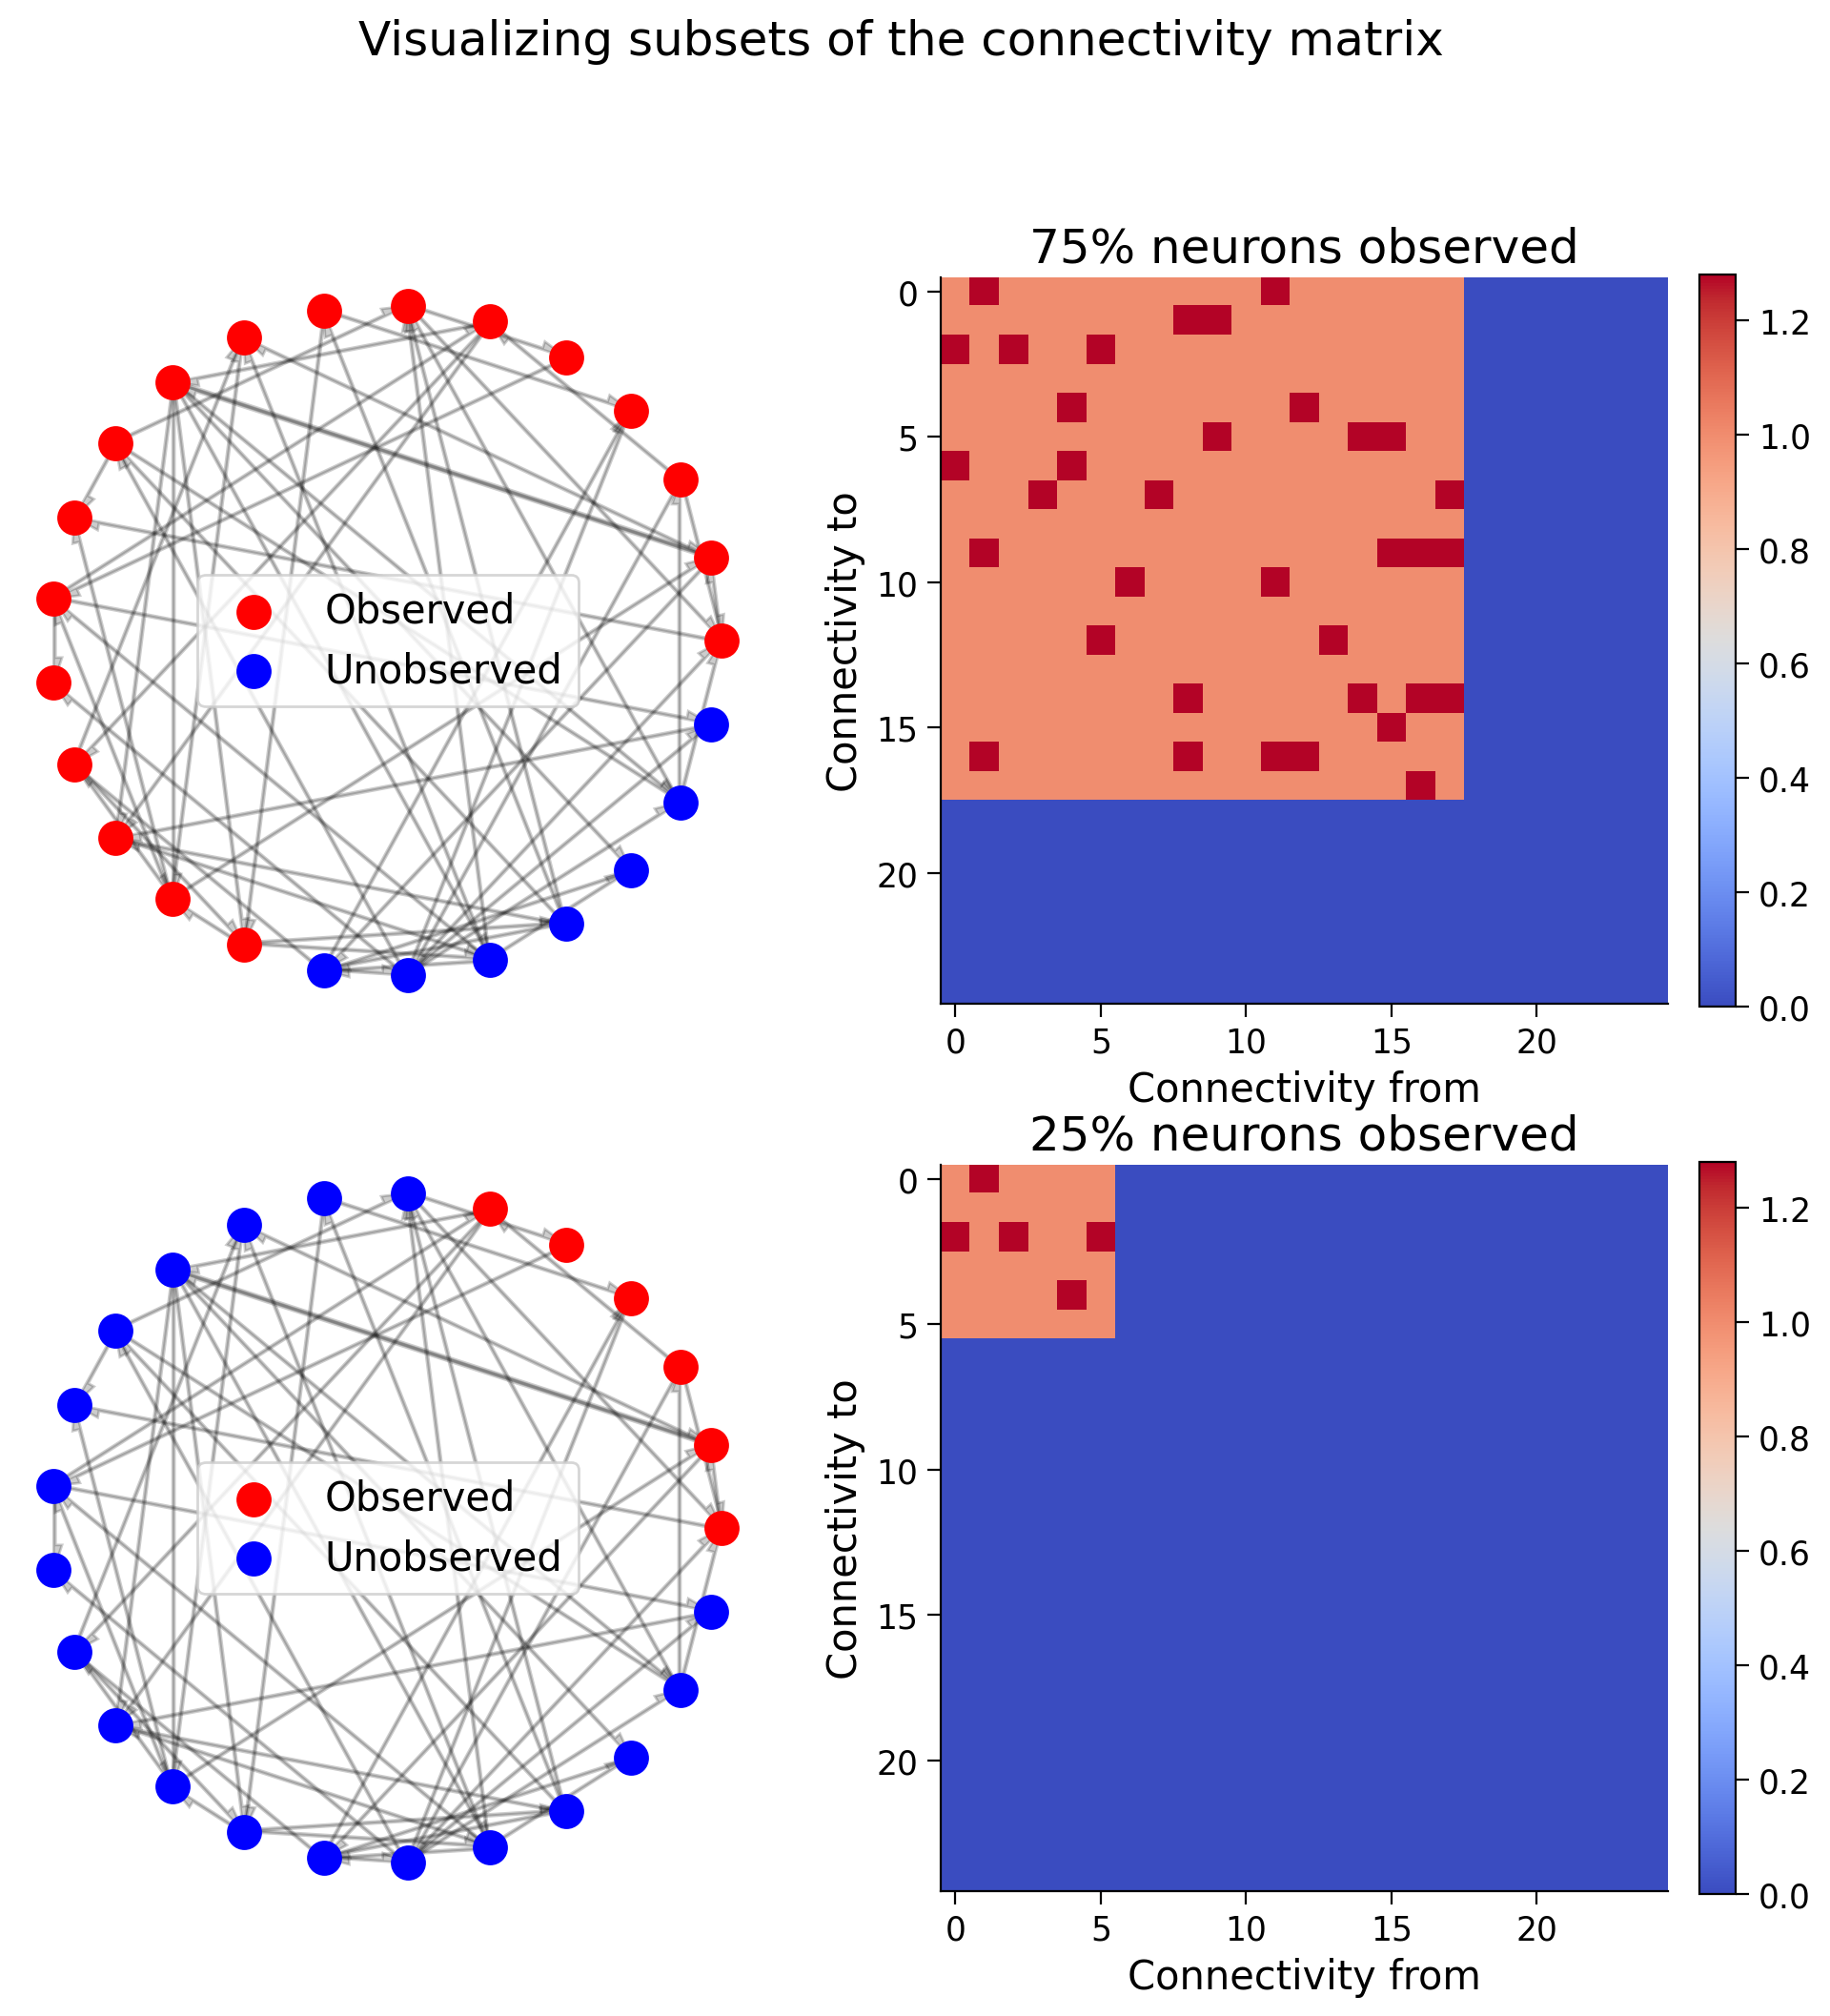

In [11]:
#@markdown Execute this cell to visualize subsets of connectivity matrix

# Run this cell to visualize the subsets of variables we observe
n_neurons = 25
A = create_connectivity(n_neurons)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
ratio_observed = [0.75, 0.25]  # the proportion of neurons observed in our system

for i, ratio in enumerate(ratio_observed):
    sel_idx = int(n_neurons * ratio)

    offset = np.zeros((n_neurons, n_neurons))
    axs[i,1].title.set_text("{}% neurons observed".format(int(ratio * 100)))
    offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
    im = axs[i, 1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
    axs[i, 1].set_xlabel("Connectivity from")
    axs[i, 1].set_ylabel("Connectivity to")
    plt.colorbar(im, ax=axs[i, 1], fraction=0.046, pad=0.04)
    see_neurons(A,axs[i, 0],ratio)

plt.suptitle("Visualizing subsets of the connectivity matrix", y = 1.05)
plt.show()

### Interactive Demo 3: Regression performance as a function of the number of observed neurons

We will first change the number of observed neurons in the network and inspect the resulting estimates of connectivity in this interactive demo. How does the estimated connectivity differ?

 Execute this cell to get helper functions `get_regression_estimate_full_connectivity` and `get_regression_corr_full_connectivity`


In [12]:
# @markdown Execute this cell to get helper functions `get_regression_estimate_full_connectivity` and `get_regression_corr_full_connectivity`

def get_regression_estimate_full_connectivity(X):
    """
    Estimates the connectivity matrix using lasso regression.

    Args:
        X (np.ndarray): our simulated system of shape (n_neurons, timesteps)
        neuron_idx (int): optionally provide a neuron idx to compute connectivity for
    Returns:
        V (np.ndarray): estimated connectivity matrix of shape (n_neurons, n_neurons).
                        if neuron_idx is specified, V is of shape (n_neurons,).
    """
    n_neurons = X.shape[0]

    # Extract Y and W as defined above
    W = X[:, :-1].transpose()
    Y = X[:, 1:].transpose()

    # apply inverse sigmoid transformation
    Y = logit(Y)

    # fit multioutput regression
    reg = MultiOutputRegressor(Lasso(fit_intercept=False,
                                     alpha=0.01, max_iter=250 ), n_jobs=-1)
    reg.fit(W, Y)

    V = np.zeros((n_neurons, n_neurons))
    for i, estimator in enumerate(reg.estimators_):
        V[i, :] = estimator.coef_

    return V


def get_regression_corr_full_connectivity(n_neurons, A, X, observed_ratio, regression_args):
    """
    A wrapper function for our correlation calculations between A and the V estimated
    from regression.

    Args:
        n_neurons (int): number of neurons
        A (np.ndarray): connectivity matrix
        X (np.ndarray): dynamical system
        observed_ratio (float): the proportion of n_neurons observed, must be betweem 0 and 1.
        regression_args (dict): dictionary of lasso regression arguments and hyperparameters

    Returns:
        A single float correlation value representing the similarity between A and R
    """
    assert (observed_ratio > 0) and (observed_ratio <= 1)

    sel_idx = np.clip(int(n_neurons*observed_ratio), 1, n_neurons)

    sel_X = X[:sel_idx, :]
    sel_A = A[:sel_idx, :sel_idx]

    sel_V = get_regression_estimate_full_connectivity(sel_X)
    return np.corrcoef(sel_A.flatten(), sel_V.flatten())[1,0], sel_V

 Execute this cell to enable demo. the plots will take a few seconds to update after moving the slider.


In [13]:
# @markdown Execute this cell to enable demo. the plots will take a few seconds to update after moving the slider.

n_neurons = 50
A = create_connectivity(n_neurons, random_state=42)
X = simulate_neurons(A, 4000, random_state=42)

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

@widgets.interact(n_observed = widgets.IntSlider(min = 5, max = 45, step = 5, continuous_update=False))
def plot_observed(n_observed):
  to_neuron = 0
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  sel_idx = n_observed
  ratio = (n_observed) / n_neurons
  offset = np.zeros((n_neurons, n_neurons))
  axs[0].title.set_text("{}% neurons observed".format(int(ratio * 100)))
  offset[:sel_idx, :sel_idx] =  1 + A[:sel_idx, :sel_idx]
  im = axs[1].imshow(offset, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

  see_neurons(A,axs[0], ratio, False)
  corr, R =  get_regression_corr_full_connectivity(n_neurons,
                                  A,
                                  X,
                                  ratio,
                                  reg_args)

  #rect = patches.Rectangle((-.5,to_neuron-.5),n_observed,1,linewidth=2,edgecolor='k',facecolor='none')
  #axs[1].add_patch(rect)
  big_R = np.zeros(A.shape)
  big_R[:sel_idx, :sel_idx] =  1 + R
  #big_R[to_neuron, :sel_idx] =  1 + R
  im = axs[2].imshow(big_R, cmap="coolwarm", vmin=0, vmax=A.max() + 1)
  plt.colorbar(im, ax=axs[2],fraction=0.046, pad=0.04)
  c = 'w' if n_observed<(n_neurons-3) else 'k'
  axs[2].text(0,n_observed+3,"Correlation : {:.2f}".format(corr), color=c, size=15)
  #axs[2].axis("off")
  axs[1].title.set_text("True connectivity")
  axs[1].set_xlabel("Connectivity from")
  axs[1].set_ylabel("Connectivity to")

  axs[2].title.set_text("Estimated connectivity")
  axs[2].set_xlabel("Connectivity from")
  #axs[2].set_ylabel("Connectivity to")

interactive(children=(IntSlider(value=5, continuous_update=False, description='n_observed', max=45, min=5, ste…

Next, we will inspect a plot of the correlation between true and estimated connectivity matrices vs the percent of neurons observed over multiple trials.
What is the relationship that you see between performance and the number of neurons observed?

**Note:** the cell below will take about 25-30 seconds to run.

 Plot correlation vs. subsampling


simulating trial 1 of 3


/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.035e-01, tolerance: 6.170e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e+00, tolerance: 5.991e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.612e+01, tolerance: 8.502e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.205e+00, tolerance: 9.716e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e+00, tolerance: 6.815e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.089e-01, tolerance: 6.599e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e+00, tolerance: 7.693e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e+00, tolerance: 7.440e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.637e-01, tolerance: 6.640e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e+00, tolerance: 7.605e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.204e-01, tolerance: 6.170e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.021e-01, tolerance: 5.991e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+00, tolerance: 7.325e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.122e+00, tolerance: 6.599e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.340e-01, tolerance: 6.522e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e+00, tolerance: 6.617e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.419e+00, tolerance: 7.297e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.904e+00, tolerance: 1.037e+00
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+00, tolerance: 1.037e+00
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.514e+00, tolerance: 8.502e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

simulating trial 2 of 3


/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.023e-01, tolerance: 6.741e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e+00, tolerance: 7.361e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.720e-01, tolerance: 5.902e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e+00, tolerance: 7.739e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e+00, tolerance: 7.932e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.575e+01, tolerance: 8.446e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.719e-01, tolerance: 5.862e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.998e-01, tolerance: 6.702e-01
  model = cd_fast.enet_coordinate_descent(


/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.094e-01, tolerance: 6.741e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e+00, tolerance: 7.361e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.977e-01, tolerance: 6.159e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.171e+00, tolerance: 7.739e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e+01, tolerance: 8.446e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.232e+01, tolerance: 1.165e+00
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.226e+00, tolerance: 8.649e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e+00, tolerance: 6.262e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e+00, tolerance: 8.649e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.679e+00, tolerance: 9.632e-01
  model = cd_fast.enet_coordinate_descent(


simulating trial 3 of 3


/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.731e-01, tolerance: 6.676e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e+00, tolerance: 6.124e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.344e+00, tolerance: 8.328e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.512e+00, tolerance: 9.272e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e+00, tolerance: 7.797e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.462e+00, tolerance: 7.751e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.263e-01, tolerance: 6.171e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.577e-01, tolerance: 5.916e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.468e-01, tolerance: 6.390e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e+00, tolerance: 6.547e-01
  model = cd_fast.enet_coordinate_descent(


/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.916e-01, tolerance: 6.178e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.255e-01, tolerance: 6.124e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.873e+00, tolerance: 1.073e+00
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e+00, tolerance: 7.096e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e+00, tolerance: 7.435e-01
  model = cd_fast.enet_coordinate_descent(


/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.202e-01, tolerance: 6.539e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.476e+00, tolerance: 8.507e-01
  model = cd_fast.enet_coordinate_descent(
/home/runner/work/course-content/course-content/.tox/run/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase 

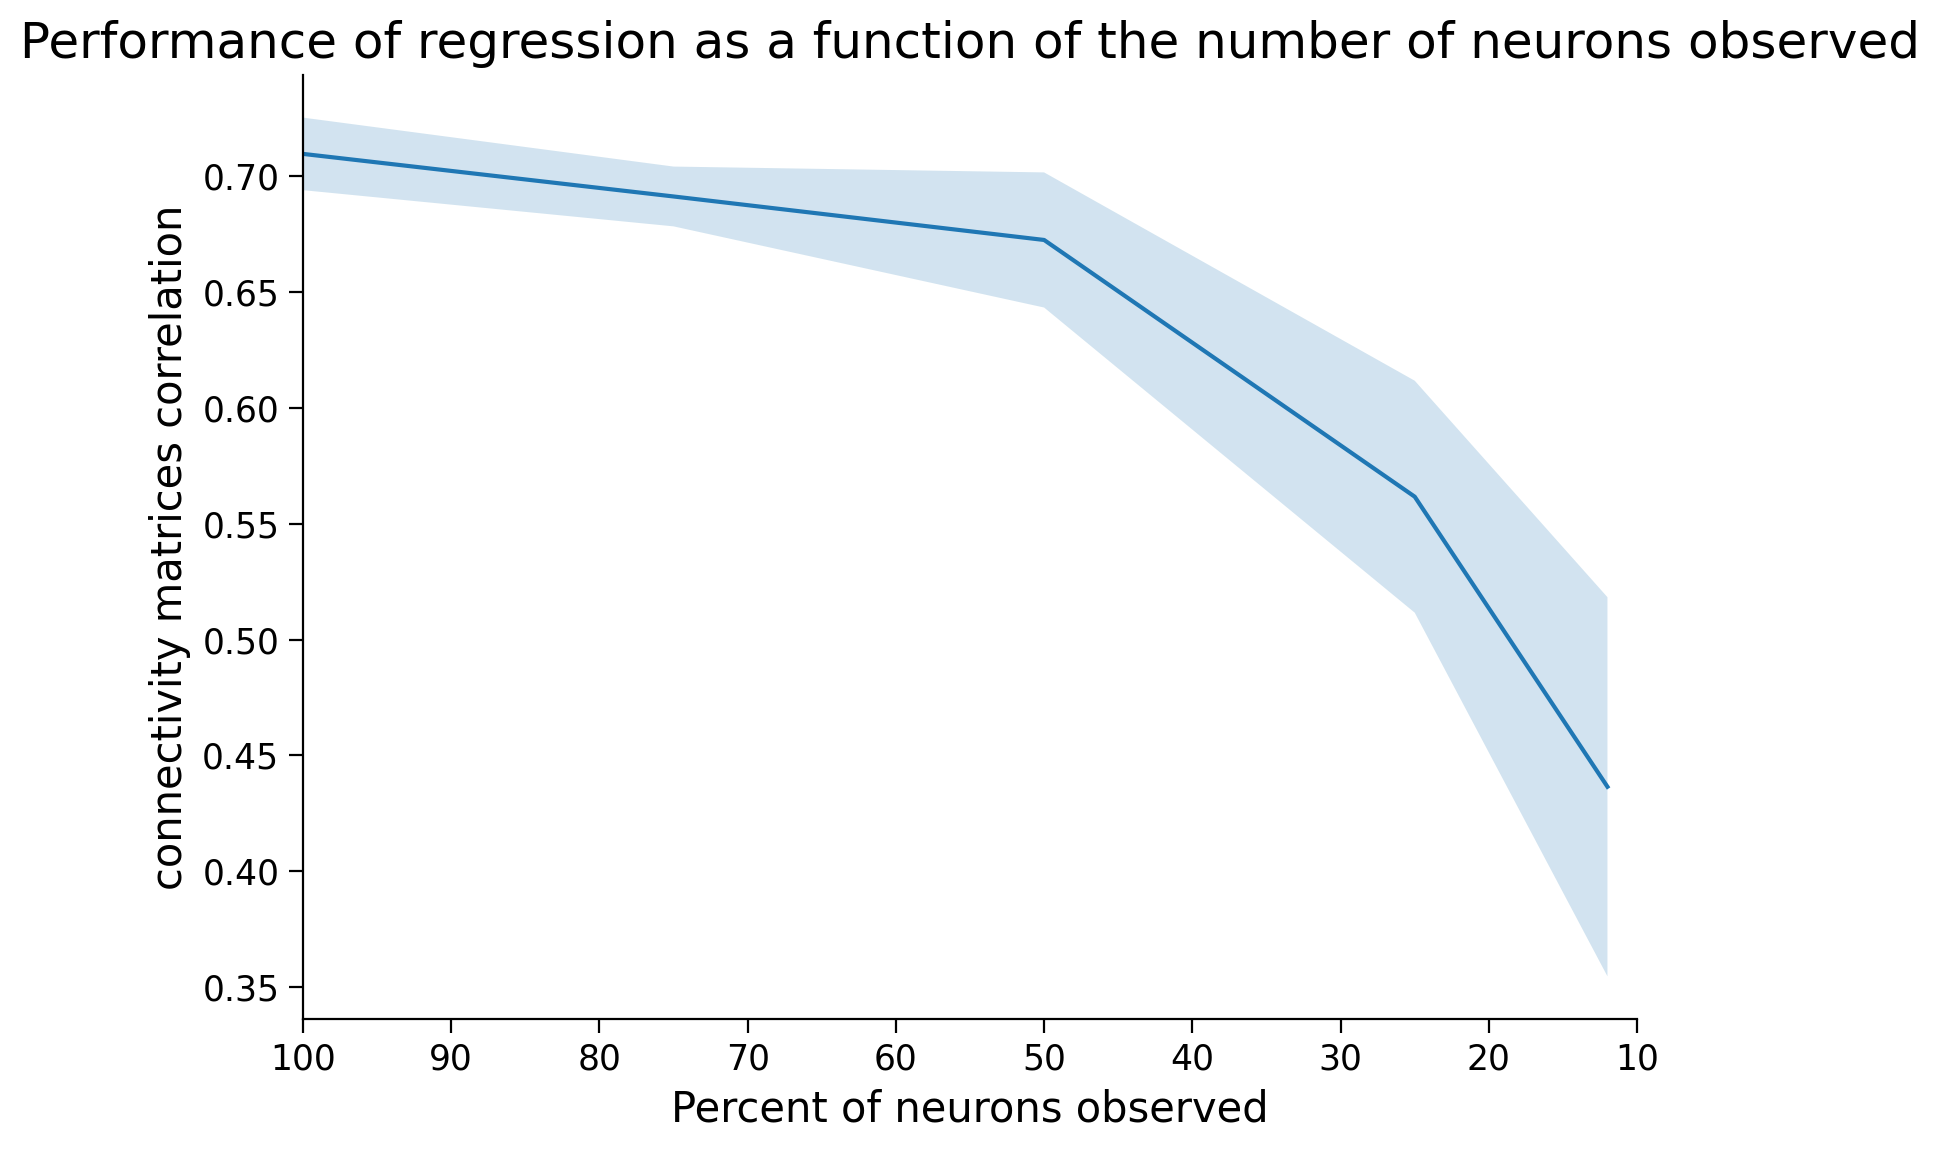

In [14]:
# @markdown Plot correlation vs. subsampling
import warnings
warnings.filterwarnings('ignore')

# we'll simulate many systems for various ratios of observed neurons
n_neurons = 50
timesteps = 5000
ratio_observed = [1, 0.75, 0.5, .25, .12]  # the proportion of neurons observed in our system
n_trials = 3  # run it this many times to get variability in our results

reg_args = {
    "fit_intercept": False,
    "alpha": 0.001
}

corr_data = np.zeros((n_trials, len(ratio_observed)))
for trial in range(n_trials):

  A = create_connectivity(n_neurons, random_state=trial)
  X = simulate_neurons(A, timesteps)
  print("simulating trial {} of {}".format(trial + 1, n_trials))


  for j, ratio in enumerate(ratio_observed):
      result,_ = get_regression_corr_full_connectivity(n_neurons,
                                    A,
                                    X,
                                    ratio,
                                    reg_args)
      corr_data[trial, j] = result

corr_mean = np.nanmean(corr_data, axis=0)
corr_std = np.nanstd(corr_data, axis=0)

plt.plot(np.asarray(ratio_observed) * 100, corr_mean)
plt.fill_between(np.asarray(ratio_observed) * 100,
                    corr_mean - corr_std,
                    corr_mean + corr_std,
                    alpha=.2)
plt.xlim([100, 10])
plt.xlabel("Percent of neurons observed")
plt.ylabel("connectivity matrices correlation")
plt.title("Performance of regression as a function of the number of neurons observed");

---
# Summary

*Estimated timing of tutorial: 20 min*

##  Video 4: Summary


In [15]:
# @title Video 4: Summary
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
      def __init__(self, id, page=1, width=400, height=300, **kwargs):
          self.id=id
          src = 'https://player.bilibili.com/player.html?bvid={0}&page={1}'.format(id, page)
          super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id="BV1bh411o73r", width=730, height=410, fs=1)
  print('Video available at https://www.bilibili.com/video/{0}'.format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id="T1uGf1H31wE", width=730, height=410, fs=1, rel=0)
  print('Video available at https://youtube.com/watch?v=' + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.titles = ['Youtube', 'Bilibili']

display(out)

In this tutorial, we explored:

1. Using regression for estimating causality
2. The problem of omitted variable bias, and how it arises in practice